In [1]:
# Import
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## FUNCTIONS IN ROTMOD:
- fcopy : I think this takes user input
- sortradii : sorts radii in ascending order
- getfactor : conversion from arcsec to kpc using distance as an input
- getrandd : takes the radial density profile from user and converts it to the right units
- getfile : get the name of the file where we want to store results

__Disk:__
- func : Casertano's equations: Eq 5 and elliptical functions 
- denzed : deciding which density function to use
- intzed : integrating the density function but not sure which step this is in Casertano's paper
- interpd : Lagrange interpolation (second order)
- interg : integration and returns velocity squared
- rotdisk : combines all functions in order:
     1. get density law 
     2. we need to know what kind of density distribution the user wants to supply. Choices are: 
          * TRUNCATED-EXPONENTIAL-DISK             USER=N
          * USER-SUPPLIED R and S(R) pairs         USER=Y
     3. get the surface densities from the user
     4. calculate the surface densities: this is where they use the piecewise function from Casertano's paper Eq 3. 
     5. try to fit an exponential and fit H and DENS0
     6. determine the disk mass and allow the user to modify it
     7. get radii for which we should calculate the rotation curve
     8. calculation
            
__BULGE:__
- interpb : 
- mu : 
- one : 
- two : 
- sign : 
- tintd : 
- rotbulge : combines all functions in order:
     1. determine the bulge mass and allow the user to modify it
     2. get radii for which we should calculate the rotation curve
     3. calculation

# ROTDISK

In [2]:
# USER= 
# UNITS=KPC,MAG/ARCSEC**2 
# TYPE= 
# ZLAW=SECH-SQUARE 
# RADII=1:13:0.01 
# Z0=.93 
# RADDENS=<NGC5005-disk_kpc 
# FILE=disk_from-mag.dat 
# DISTANCE=16.5 
# MASS=1

## User input: 
- __Density law:__<br>
     Case 1: flat disk: z0=0<br>
     Case 2: the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)^2/Z0<br>
     Case 3: an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 <br>
     Case 4: a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI <br><br>
- __User supplies density distribution:__<br>
     NO: USER=N, Truncated-exponential disk<br>
     YES: USER=Y, radius and density pairs provided<br><br>
- __Units:__<br>
     'KPC,MSUN/PC\*\*2'<br>
     'ARCSEC,MAG/ARCSEC\*\*2'

In [3]:
# User input
user = True             # user = False means NO (let program calculate density) 
                        # user = True means YES (radius-density provided)
units = 'KPC,MSUN/PC**2'
zlaw = 2                # Case 2: sech-squared density law
z0 = 0.93
raddens = "../data/gasmsd_kpc_linear.txt"         # Gas density with 2 columns, units: KPC, MSUN/PC^2
#raddens = "../data/NGC5005-disk_arcsec.txt"      # Disk density with 4 columns, units: ARCSEC, MAG/ARCSEC^2
file = 'output.txt'
distance = 16.5         # distance in MPC
#mass = 0                # disk mass
#dens0 = 21.27           # central density of exponential DISK in MAG/ARCSEC^2
#h = 10.0                # radial scale length (guessed this to be the outer scale length from Paper 13)

## Parameters

In [4]:
# Parameters 
G = 0.00000431158              # gravitational constant (KPC/MSUN*(KM/S)^2)  
#LEN1 = 20016   #don't need to pre-define array size in python
#LEN2 = 40001
#LEN2 = len(rkpc)              
CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 0.000001
naccur = 1                     # GUESS -> accuracy of calculations, range between 1-10, 
                               # The programme needs more time for higher accuracies. 
                               # If no ZLAW is specified, the accuracy parameter is always 10

## Surface densities

### Check units

The accepted units are radius in KPC and density in MSUN/PC^2. <br>
If this isn't the case, the units need to be converted.<br>
The conversion goes as follows: <br>
- from ARCSEC to KPC: RADIUS in KPC = 4.8481E-3 * DISTANCE * RADIUS in ARCSEC
- from MAGnitudes to MSUN: M = 10^(- 0.4 * MAG)<br>
- from $ \rm PC^{-2}$ to $\rm KPC^{-2}$: DENSITY * 1.0E6

In [5]:
# This checks if the user has provided density ditribution data (i.e. radius-density pairs or not)
if user == True:            # Choose user==True for density data, == False otherwise 
    
    if units == 'KPC,MSUN/PC**2':
        mudata = np.loadtxt(raddens)
        if np.shape(np.loadtxt(raddens))[1] == 2:
            xdinp, ydinp = mudata.T
        if np.shape(np.loadtxt(raddens))[1] == 4:
            xdinp, ydinp, xerror, yerror = mudata.T
        
    if units == 'ARCSEC,MAG/ARCSEC**2':
        mudata = np.loadtxt(raddens)
        if np.shape(np.loadtxt(raddens))[1] == 2:
            xdinp, ydinp = mudata.T
        if np.shape(np.loadtxt(raddens))[1] == 4:
            xdinp, ydinp, xerror, yerror = mudata.T
                
        # Conversion
        # ARCSEC to KPC
        xdinp = 4.8481E-3 * distance * xdinp

        # MAG/ARCSEC^2 to MSUN/PC^2
        ydinp = 10**(-0.4 * ydinp)
        ydinp = (4.8481E-3 * distance)**(-2) * ydinp
    
    LEN1 = len(xdinp)
    LEN2 = len(ydinp)
    ndinp = LEN2-1                 # number of surface densities ????
    rcut = xdinp[ndinp-1]
    delta = rcut - xdinp[ndinp-2]
    #rdinp = rcut + delta               # max radius, where galaxy ends
    #xstep = rdinp / (ndinp - 1)        # step in radius
        
    print("Rcut = {:.4} kpc".format(rcut))
    print("Delta = {:.4} kpc".format(delta))
    
    # Now try to fit an exponential and fit H and DENS0
    s = 0.0
    sx = 0.0
    sy = 0.0
    sxy = 0.0
    sxx = 0.0
    n = 0
    while n < ndinp:
        if ydinp[n] > 0.0:
            s += 1.0
            sx += xdinp[n]
            sxx += xdinp[n] * xdinp[n]
            sy += np.log(ydinp[n])
            sxy += xdinp[n] * np.log(ydinp[n])
        n += 1
    det = s * sxx - sx * sx;
    h = det / ( sx * sy - s * sxy )
    if ( h > ( 0.5 * rcut ) ):
        h = 0.5 * rcut
    if ( h < ( 0.1 * rcut ) ):
        h = 0.1 * rcut;
    dens0 = np.exp( ( sy * sxx - sx * sxy ) / det )
        
    print("dens0 = {:.4} Msun/PC^2".format(dens0))
    print("h = {:.4} kpc".format(h))
'''
if user == False:           # If USER=N, calculate density

    # User need to provide dens0 (in MSUN/PC^2) and h (in KPC)
    dens0 = dens0          # central density of exponential DISK in MAG/ARCSEC^2
    # convert disk central surface brightness from MAG/ARCSEC^2 to MSUN/KPC^2
    dens0 = 10**(-0.4 * dens0)       
    dens0 = (4.8481E-3 * distance)**(-2) * dens0
    dens0 = dens0 * 1.0e6        
    print("dens0 = {:.4}".format(dens0))

    h = h                   # radial scale length
    z0 = 0.2*h              # scale height of DISK in kpc [0.0]. 
                              # note: The integration in Z is the most time consuming part
                              # of the calculation. For example it takes about 0.2 seconds
                              # to calculate a point on the rotation curve for a disk with zero
                              # thickness, and about 2 seconds for a disk with non-zero thickness.
    rcut = 4*h              # cutoff radius
    delta = 0.2*h           # softening parameter of DISK in kpc [0.0]. It may be wise
                              # to have a non-zero softening in case of a truncated disk, 
                              # because then the sharp features in the calculated rotation 
                              # curve will be smoothed out. A softening parameter of about 
                              # 0.2 scale lengths would be sufficient.

    # Now calculate the surface densities
    xdinp = np.zeros(LEN2)    # radii surface density
    ydinp = np.zeros(LEN2)    # surface densities
    rdinp = rcut + delta      # max radius, where galaxy ends
    ndinp = LEN2 - 1          # number of surface densities
    xstep = rdinp / (ndinp - 1)        # step in radius

    i = 0                              # counter 
    while i < ndinp:
        xdinp[i] = x = xstep * i
        if ((x >= rcut) & (delta > 0.0)):
            y = dens0 * np.exp(-rcut / h) * (rcut + delta - x) / delta
        if (x >= rdinp):
            y = 0.0                    # end of disk
        else:
            y = dens0 * np.exp(-x / h) # exponential disk
        ydinp[i] = y
        i += 1
    print(len(xdinp))
    print(xdinp[1])
    print(len(ydinp))
'''

Rcut = 11.16 kpc
Delta = 0.0259 kpc
dens0 = 169.4 Msun/PC^2
h = 1.948 kpc


'\nif user == False:           # If USER=N, calculate density\n\n    # User need to provide dens0 (in MSUN/PC^2) and h (in KPC)\n    dens0 = dens0          # central density of exponential DISK in MAG/ARCSEC^2\n    # convert disk central surface brightness from MAG/ARCSEC^2 to MSUN/KPC^2\n    dens0 = 10**(-0.4 * dens0)       \n    dens0 = (4.8481E-3 * distance)**(-2) * dens0\n    dens0 = dens0 * 1.0e6        \n    print("dens0 = {:.4}".format(dens0))\n\n    h = h                   # radial scale length\n    z0 = 0.2*h              # scale height of DISK in kpc [0.0]. \n                              # note: The integration in Z is the most time consuming part\n                              # of the calculation. For example it takes about 0.2 seconds\n                              # to calculate a point on the rotation curve for a disk with zero\n                              # thickness, and about 2 seconds for a disk with non-zero thickness.\n    rcut = 4*h              # cutoff radius

In [6]:
#should be 4.183 10^9 solar masses (Msun)
# Now we determine the disk mass and allow the user to modify it.
dkmass = 0.0
n = 1
print(ndinp)
print(len(xdinp))
while n < ndinp:
    x = xdinp[n]
    if n < ndinp - 1:
        step = ( xdinp[n+1] - xdinp[n-1] ) / 2.0
    else:
        step = xdinp[n] - xdinp[n-1]
    dkmass += ydinp[n] * step * x    
    n += 1
dkmass *= ( 2.0 * np.pi )
rmass = dkmass / 1.0e9
print("Disk Mass in 10^9 MSUN {:.4}.".format(rmass))
print(dkmass)
#this is where you would put in your own mass value**
#i.e rmass=91.6
rmass=4.183
if ( rmass <= 0.0 ):
    print("error in disk mass")
        
rmass = ( rmass * 1.0E9 ) / dkmass
dkmass = rmass * dkmass;
    
n = 0
while n < ndinp:
    ydinp[n] *= rmass
    n += 1
dens0 = dens0 * rmass
z1 = z0
if ( z1 < ( 0.1 * h ) ):
    z1 = 0.1 * h
if ( z1 > ( 0.3 * h ) ):
    z1 = 0.3 * h

print("dens0 = {:.4e}.".format(dens0))
print("dkmass = {:.4e}.".format(dkmass))
print(rmass)

145
146
Disk Mass in 10^9 MSUN 3.851e-06.
3850.7728948939916
dens0 = 1.8400e+08.
dkmass = 4.1830e+09.
1086275.434613797


In [7]:
# Now get radii for which we should calculate the rotation curve.
radii = xdinp                   # GUESS -> sampling radii
radius = np.zeros(LEN2)

nring = len(radii)              # number of sampling radii
rings = radii
ntimes = LEN1              # number of items
   
while n < nring:
    if rings[n] < 0.0:
        print("error in rings")
    n += 1
    
nitems = 1
input_level = 2
    
if z1 < delta:
    width = z1
else:
    width = delta

if ( user == False ):
    if width != 0.0 :
        
        s1 = rcut - width
        s2 = rcut + 2.0 * width
        indmin = indmax = nring - 1
        n = 0
        while n < nring:
            if ( rings[n] > s1 ): 
                if indmin < n:
                    indmin = indmin
                else: 
                    indmin = n
            if ( rings[n] > s2 ):
                if indmax < n:
                    indmax = indmax
                else: 
                    indmax = n
            n += 1
        
        m = n = 0
        while n < nring:
            if ( n < indmin or n > indmax ):
                radius[m+2] = rings[n]
            if ( n == indmin ):
                stp = width / 5.0
                l = 0
                while l < 15:
                    radius[m+2] = rcut - width * l * stp
                    l += 1
            else:
                radius[m+2] = rings[n]
            n += 1
            
        nradii = m
'''
#if ( user == True ):
# This isn't working and not understanding what it does.
    r1 = 0.0
    r2 = 0.0

    radius[0] = 0.0
    l = m = n = 0
    while ( ( l < nring or n < ndinp ) & m < ( LEN1 + LEN2 + 1 ) ):
        while ( ( l < nring ) & ( radius[m] >= r1 ):
               r1 = rings[l]
               l += 1
        while ( n < ndinp & radius[m] >= ( r2 = xdinp[n] ) ):
            n += 1
        if ( r1 > radius[m] & r2 > radius[m] ):
            if r1 < r2:
                radius[m-2] = r1
            else:
                radius[m-2] = r2
        elif ( r1 > radius[m] ):
            radius[m-2] = r1
        elif ( r2 > radius[m] ):
            radius[m-2] = r2
    nradii = m + 1;
else:
    nradii = 0
    n = 0
    while n < nring:
        radius[nradii+2] = rings[n] 
        n += 1
        
'''

"\n#if ( user == True ):\n# This isn't working and not understanding what it does.\n    r1 = 0.0\n    r2 = 0.0\n\n    radius[0] = 0.0\n    l = m = n = 0\n    while ( ( l < nring or n < ndinp ) & m < ( LEN1 + LEN2 + 1 ) ):\n        while ( ( l < nring ) & ( radius[m] >= r1 ):\n               r1 = rings[l]\n               l += 1\n        while ( n < ndinp & radius[m] >= ( r2 = xdinp[n] ) ):\n            n += 1\n        if ( r1 > radius[m] & r2 > radius[m] ):\n            if r1 < r2:\n                radius[m-2] = r1\n            else:\n                radius[m-2] = r2\n        elif ( r1 > radius[m] ):\n            radius[m-2] = r1\n        elif ( r2 > radius[m] ):\n            radius[m-2] = r2\n    nradii = m + 1;\nelse:\n    nradii = 0\n    n = 0\n    while n < nring:\n        radius[nradii+2] = rings[n] \n        n += 1\n        \n"

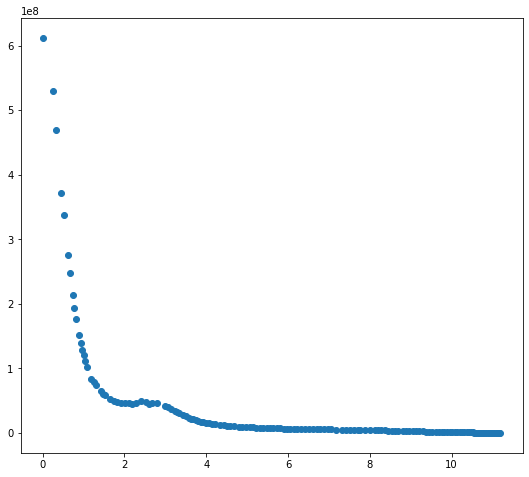

In [8]:
# Plot 
plt.figure(figsize=(9,8))
plt.scatter(xdinp,ydinp)
plt.show()

In [9]:
# Definitions
def func(x,y,z):
    if( x==y ) & ( z == 0):
        r = 0
    elif( x==0 ) | ( y == 0):
        r = 0
    else:
        xxx = (x*x + y*y + z*z) / (2.0 * x * y)
        rrr = (xxx*xxx - 1.0)
        ppp = 1.0 / (xxx + np.sqrt(rrr))
        fm = 1.0 - ppp*ppp
        el1 = (1.3862944 + fm * (0.1119723 + fm * 0.0725296)) - (0.5 + fm * (0.1213478 + fm * 0.0288729)) * np.log(fm)
        el2 = (1.0 + fm * ( 0.4630151 + fm * 0.1077812 ) ) - (fm * (0.2452727 + fm * 0.0412496)) * np.log(fm)
        r = ((1.0 - xxx * y/x) * el2 / (rrr) + (y/x - ppp) * el1 / np.sqrt(rrr)) / np.pi
        r *= np.sqrt(x / (y * ppp))
    return r

In [10]:
# DISK Density distribution 
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0

# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    r = r * r * z0
    r = 1.0 / r
    return r

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh(z/z0)
    return r

def denzed(z,z0,mode):
    #mode = input("Which Z density law? 2 or 3 or 4: ")
    #The above results in the user being asked for every point entered; this was likely used as a backend.
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case2(z,z0)
    if mode == 4:
        return denzed_case4(z,z0)
    else:
        return np.nan
        print("Error occured in denzed; no mode selected. Returned nan.")

In [11]:
"""intzed computes the integral over Z that defines the kernel of the integral formula for the rotation velocity. 
This is done for an arbitrary vertical density profile, specified in the function denzed.
The interval of integration is divided into several subintervals, in each of which Simpson's rule is used. 
It is thus possible to have different steps in different regions of the interval of integration, 
and to compute the integral more accurately. An attempt has been made at optimizing the subdivision. 
It is still possible that the kernel is not accurate, especially when R is very close to U. 
It is NOT recommended that the programme is used with very small, but non-zero, values of the thickness. 
On the other hand, the situation with an infinitely thin disk is dealt with properly, the density profile in 
Z being then treated as a Dirac delta function."""

def intzed(r,u,z0,naccur,mode):
    zeds = np.array([0.02, 0.50, 1.00, 3.00, 10.00])
    
    if (z0 != 0.0) & (naccur != 0):
        n = 10
        n = naccur * n
        
        if (np.abs(r - u) <= (0.2 * z0)) & (naccur > 1):
            n = 200
        
        zne = 0.0
        res = 0.0
        i = 0
        while i < 5: 
            zol = zne
            zne = zeds[i] * z0
            step = (zne - zol) / n
            z = zol
            res += step * func(r,u,z) * denzed(z,z0,mode) / 3.0
            w = 4.0 / 3.0         
            j = 0.0
            while j < n:
                z += step
                res += step * func(r,u,z) * denzed(z,z0,mode) * w
                w = 2.0 - w
                j += 1
            res -= step * func(r,u,z) * denzed(z,z0,mode) / 3.0
            i += 1
    else:
        res = func(r,u,z0)
    return res

In [12]:
# interp does a Lagrange interpolation (second order)
def interpd(x1,y1,n1,x2,y2,n2):
    i = 0
    j = 1
    done = 0
    n1 = len(radii)
    n2 = len(radii)

    while i < n2:
        x = x2[i]
        y = 0.0
        while (j != done) & (j < (n1 - 1)):
            if ((x1[j-1] <= x ) & (x1[j+1] >= x)):
                k = j - 1
                while (k <= j + 1):
                    f = 1.0
                    l = j - 1
                    while l <= j + 1:
                        if (l != k):
                            f *= (x - x1[l]) / (x1[k] - x1[l])
                        l += 1        
                    y += f * y1[k]
                    k += 1 
                done = 1
            j += 1
        if (y > 0.0):
            y2[i] = y
        else: 
            y2[i] =0.0
        i += 1

In [13]:
# interg does the integration
def interg(xd,yd,nd,r,rstart,z0,step,ndens,naccur,mode):
    vsq = 0.0
    i = 1
    k = 0

    while k < ndens:
        if (k == 0 or k == (ndens - 1)):
            iw = 1
        else:
            iw = 4 - 2 * ((k + 1) % 2)
        
        x = rstart + step * k
        y = 0.0

        if (x < xd[nd-1]): 
            done = False
            while (done == False) & (i < (nd - 1)):
                #if i==1:
                    #print("            Checking xd...") #This if (xd...) loop is entered many times in quick succession; doesn't seem to be hanging so much as running too much. Not seeing the "increased i for the first time" as frequently as I would have expected, but this if statement IS completing quickly.
                if (xd[i-1] <= x) & (xd[i+1] >= x):
                    k1 = i - 1
                    while k1 <= (i + 1):
                        f = 1.0
                        k2 = i - 1
                        while k2 <= (i + 1):
                            if (k1 != k2):
                                f *= (x - xd[k2]) / (xd[k1] - xd[k2])
                            k2 += 1
                        y += f * yd[k1]
                        done = True
                        k1 += 1
                else:
                    i += 1
            if (y > 0.0):
                res = intzed(r,x,z0,naccur,mode)
                vsq += CONSTANT * res * y * step * iw
        k += 1
    return vsq

In [ ]:
# Calculation
print("Setting variables...")
i = 0
j = 0
velocs = np.zeros(len(radii))
nradii = len(radii)
densit = np.zeros(LEN1+LEN2+1)

#####################################
########### USER SETTINGS ###########
#####################################
mode = zlaw

print("Variables set. Interpolating...")
interpd( xdinp, ydinp, ndinp, radii, densit, nradii )

print("Interpolation complete. Calculation will now begin.")
while i < len(radii):
    r = radii[i]
    vsq = 0.0

    if i==0:
        print("Loop variables set. Setting variable j...")
    while ((j < nring)&(rings[j] < r)):
        j += 1

    if i==0:
        print("Initial value of j set to "+str(j)+". Setting additional variables...")
    skip = rings[j] != r
    z1 = z0
    r1 = r - 3.0 * z1
    if r1 < 0.0:
           r1 = 0.0
    r2 = 0.0

    if (r1 < (rcut + 2.0 * delta)):
        r2 = r + (r - r1)
        ndens = 6 * ntimes + 1
        step = (r2 - r1) / (ndens - 1)
        rstart = r1
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur,mode)
        
        if r1 > 0.0:
            ndens = r1 * ntimes / h
            ndens = 2 * (ndens - 1)
            rstart = 0.0
            vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur,mode)
    if r2 < (rcut + 2.0 * delta):
        ndens = (rcut + 2.0 * delta - r2) * ntimes / h
        ndens = 2 * (ndens / 2) + 3
        step = (rcut + 2.0 * delta - r2) / (ndens - 1)
        rstart = r2
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur,mode)
    if vsq < 0.0:
           velocs[i] = (-np.sqrt(-vsq))
    else:
           velocs[i] = (np.sqrt(vsq))

    print("{:10.1f}".format(i/len(radii)*100)+"% Complete",end="")
    print('\r',end="")
    i += 1

Setting variables...
Variables set. Interpolating...
Interpolation complete. Calculation will now begin.
Loop variables set. Setting variable j...
Initial value of j set to 0. Setting additional variables...


In [ ]:
#plot disk velocity
fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.scatter(radii, velocs, linestyle='solid', label='Gas Velocity')

plt.axis('tight');

fig.suptitle('Disk Velocity', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
ax.set_xlim(0,11.2)
ax.set_xlabel('r (kpc)', fontsize=14)
ax.set_ylabel('v (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
#plt.savefig('DiskVelocity100pts.png')
plt.show()